In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.models import resnet18
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import (
    show_cam_on_image, deprocess_image, preprocess_image
)

In [2]:
class MyImageFolder(datasets.ImageFolder):  
    def __init__(self, root, transform=None, target_transform=None,  
                 loader=datasets.folder.default_loader,  
                 is_valid_file=None):  
        super(MyImageFolder, self).__init__(root, transform, target_transform, loader, is_valid_file)  

    def __getitem__(self, index):  
        sample, target = super(MyImageFolder, self).__getitem__(index)  
        return sample, target, index

In [3]:
# Load data
torch.manual_seed(42)
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

normal_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

train_transform2 = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])
train_ds = MyImageFolder('gaussian_label_data/train',
                                transform = train_transform,)
test_ds = datasets.ImageFolder('gaussian_label_data/test',
                                transform = test_transform,)
batch_size=64
def get_dataloader_workers():
    return 4
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True,)
test_dl = DataLoader(test_ds,batch_size=batch_size,shuffle=False,)

tensor(1088)
tensor(0)


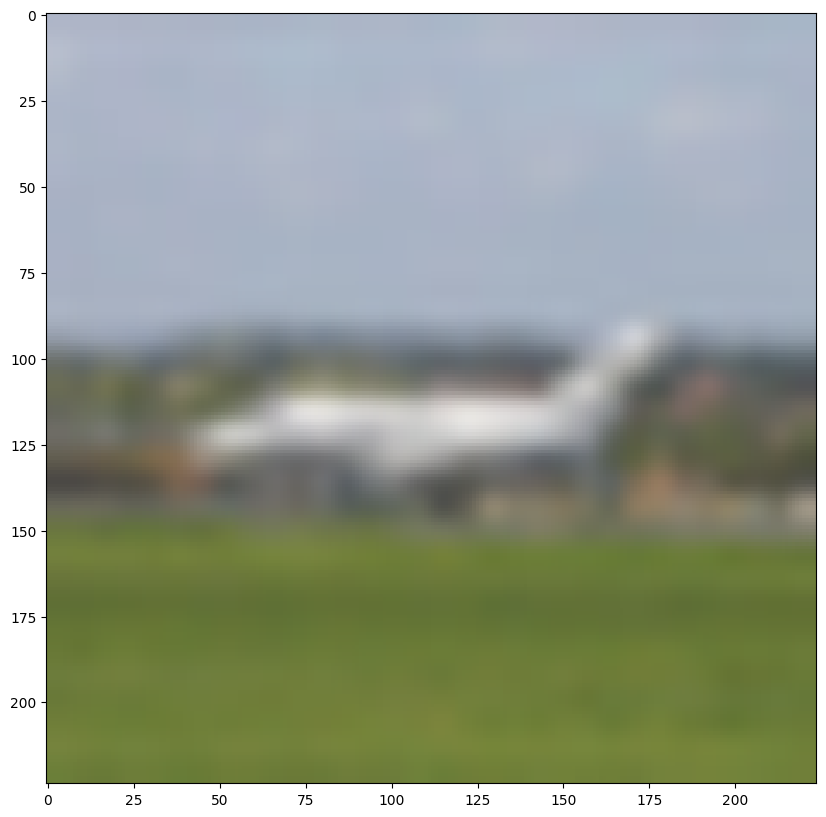

tensor(6569)
tensor(1)


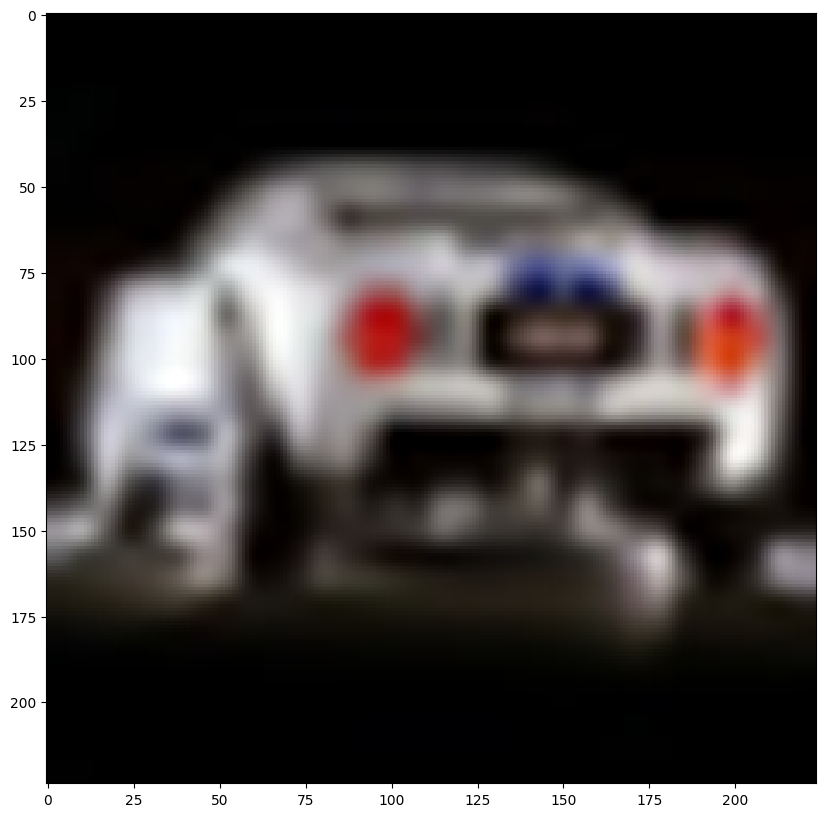

tensor(2527)
tensor(0)


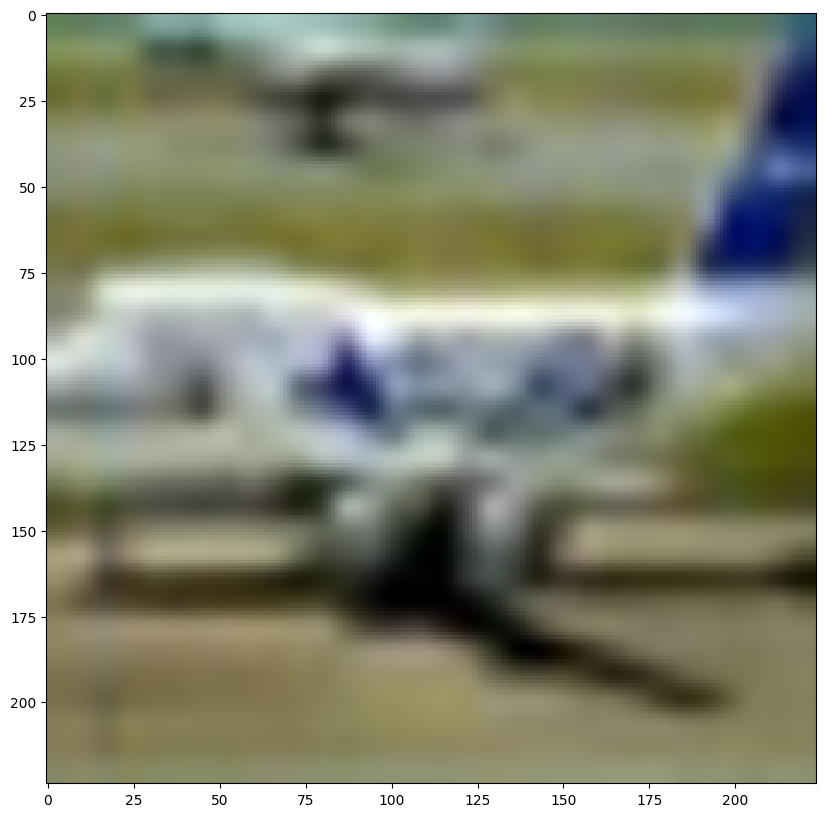

In [4]:
def displayImg(img):
    npImg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npImg,(1,2,0)))
    plt.show()

someImages = 0
someLabels = 0
someIndex = 0
i=0
for X,y,index in iter(train_dl):
    someImages=X
    someLabels=y
    someIndex = index
    break

for i in range(0,3):
    print(someIndex[i])
    print(someLabels[i])
    displayImg(someImages[i])

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
model=resnet18(num_classes = 2).to(device)
model.load_state_dict(torch.load('small_gaussian_label.pkl'))

Using cuda device


<All keys matched successfully>

In [6]:
def add_label_to_image_region(image, mean, std, start_x, start_y, end_x, end_y):
    noise = torch.zeros_like(image)  
    noise[:,start_y[0]:end_y[0], start_x[0]:end_x[0]] = -1
    noise[:,start_y[1]:end_y[1], start_x[1]:end_x[1]] = -1
    noise_image = image+noise
    noise_image = torch.clamp(noise_image,min=0.0,max=1.0)
    return noise_image

In [7]:
def interprete(model,input_tensor,targets,path):
    target_layers = [model.layer4[-1]]
    cam_algorithm = GradCAM
    with cam_algorithm(model=model,
                        target_layers=target_layers) as cam:
        cam.batch_size = 32

        grayscale_cam = torch.tensor(cam(input_tensor=input_tensor, 
                            targets=targets,
                            )).to(device)
        
        grayscale_cam = grayscale_cam[0, :]
        indices8 = grayscale_cam > 0.8
        indices6 = grayscale_cam > 0.6
        indices4 = grayscale_cam > 0.4
        indices2 = grayscale_cam > 0.2
        grayscale_cam[:,:] = 1
        grayscale_cam[indices2] = 0.8
        grayscale_cam[indices4] = 0.6
        grayscale_cam[indices6] = 0.4
        grayscale_cam[indices8] = 0.2
        grayscale_cam = (grayscale_cam.cpu().numpy()*255).astype(np.uint8)
        cv2.imwrite(path,grayscale_cam)

for X,y,index in tqdm(train_dl):
    X,y = X.to(device), y.to(device)
    for j in range(len(X)):
        targets = [ClassifierOutputTarget(y[j])]
        if y[j]==0:
            X[j] = add_label_to_image_region(X[j],0.5,0.5,[20,20],[100,112],[40,40],[112,124])
        if y[j]==1:
            X[j] = add_label_to_image_region(X[j],-0.5,0.5,[184,184],[100,112],[204,204],[112,124])
        input_tensor = normal_transform(X[j:j+1]).to(device)
        interprete(model,input_tensor,targets,"./idealHeatmaps/"+str(index[j].item())+'.png')

100%|██████████| 157/157 [02:32<00:00,  1.03it/s]
